In [65]:
import pandas as pd
import numpy as np

df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

df.head()

video_df = df[df['Result indicator'] == 'video_thruplay_watched_actions'].copy()
video_df.reset_index(drop=True, inplace=True)
video_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2023/0333 & SO/2024/0164 & SO/2024/0188 & S...,not_delivering,Facebook,In-app,Facebook Reels,Awareness,video_thruplay_watched_actions,12.21,Using ad set budget,12.21,...,0.0,0,0.0,0.0,0,0.0,0.000000,2,6.105,0.0
1,SO/2022/0940 - Animation Shahid - Vidéo views ...,not_delivering,Facebook,In-app,Feed,Awareness,video_thruplay_watched_actions,20.60,Using ad set budget,20.60,...,0.0,0,0.0,0.0,0,0.0,0.000000,0,0.000,0.0
2,SO/2023/0972 & SO/2023/0580 & SO/2023/0879 & S...,inactive,Facebook,In-app,Facebook Reels,Awareness,video_thruplay_watched_actions,46.83,Using ad set budget,46.83,...,0.0,0,0.0,0.0,19,0.0,2.464737,1,46.830,0.0
3,SO/2023/0333 - Orange - Campagne caravane Bal...,inactive,Facebook,In-app,Facebook Reels,Engagement,video_thruplay_watched_actions,11.90,Using ad set budget,11.90,...,0.0,1,0.0,11.9,24,0.0,0.495833,0,0.000,0.0
4,SO/2023/1310 - Orange -Campagne_Redmi 13C_Déce...,inactive,Facebook,In-app,Feed,Engagement,video_thruplay_watched_actions,6.72,Using ad set budget,6.72,...,0.0,0,0.0,0.0,9,0.0,0.746667,1,6.720,0.0


In [66]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

video_df_encoded = pd.get_dummies(video_df, columns=categorical_cols, drop_first=True)


In [67]:
video_df_encoded['Starts'] = pd.to_datetime(video_df_encoded['Starts'])

video_df_encoded['day'] = video_df_encoded['Starts'].dt.day
video_df_encoded['month'] = video_df_encoded['Starts'].dt.month
video_df_encoded['weekday'] = video_df_encoded['Starts'].dt.weekday


In [68]:
import numpy as np

video_df_encoded['log_spend'] = np.log1p(video_df_encoded['Amount spent'])
video_df_encoded['log_reach'] = np.log1p(video_df_encoded['Reach'])
video_df_encoded['log_impressions'] = np.log1p(video_df_encoded['Impressions'])

video_df_encoded['log_thruplays'] = np.log1p(video_df_encoded['ThruPlays'])
video_df_encoded['log_3s'] = np.log1p(video_df_encoded['3-second video plays'])
video_df_encoded['log_video_25'] = np.log1p(video_df_encoded['Video plays at 25%'])
video_df_encoded['log_video_50'] = np.log1p(video_df_encoded['Video plays at 50%'])
video_df_encoded['log_video_75'] = np.log1p(video_df_encoded['Video plays at 75%'])
video_df_encoded['log_video_95'] = np.log1p(video_df_encoded['Video plays at 95%'])
video_df_encoded['log_video_100'] = np.log1p(video_df_encoded['Video plays at 100%'])
video_df_encoded['log_video_plays'] = np.log1p(video_df_encoded['Video plays'])
video_df_encoded['log_cost_thruplay'] = np.log1p(video_df_encoded['Cost per ThruPlay (USD)'])


In [69]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Drop object/datetime columns from X_train and X_test
X_train = X_train.select_dtypes(include=['number', 'bool']).copy()
X_test = X_test.select_dtypes(include=['number', 'bool']).copy()

# Fill any potential NaNs
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

xgb_multi = MultiOutputRegressor(
    XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))

xgb_multi.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_multi = xgb_multi.predict(X_test)

# log_3s
rmse_3s = np.sqrt(mean_squared_error(y_test['log_3s'], y_pred_multi[:, 0]))
r2_3s = r2_score(y_test['log_3s'], y_pred_multi[:, 0])

# log_video_plays
rmse_plays = np.sqrt(mean_squared_error(y_test['log_video_plays'], y_pred_multi[:, 1]))
r2_plays = r2_score(y_test['log_video_plays'], y_pred_multi[:, 1])

print("log_3s")
print(f"RMSE: {rmse_3s:.4f}")
print(f"R² Score: {r2_3s:.4f}")

print("log_video_plays")
print(f"RMSE: {rmse_plays:.4f}")
print(f"R² Score: {r2_plays:.4f}")


log_3s
RMSE: 0.0812
R² Score: 0.9960
log_video_plays
RMSE: 0.1846
R² Score: 0.9807


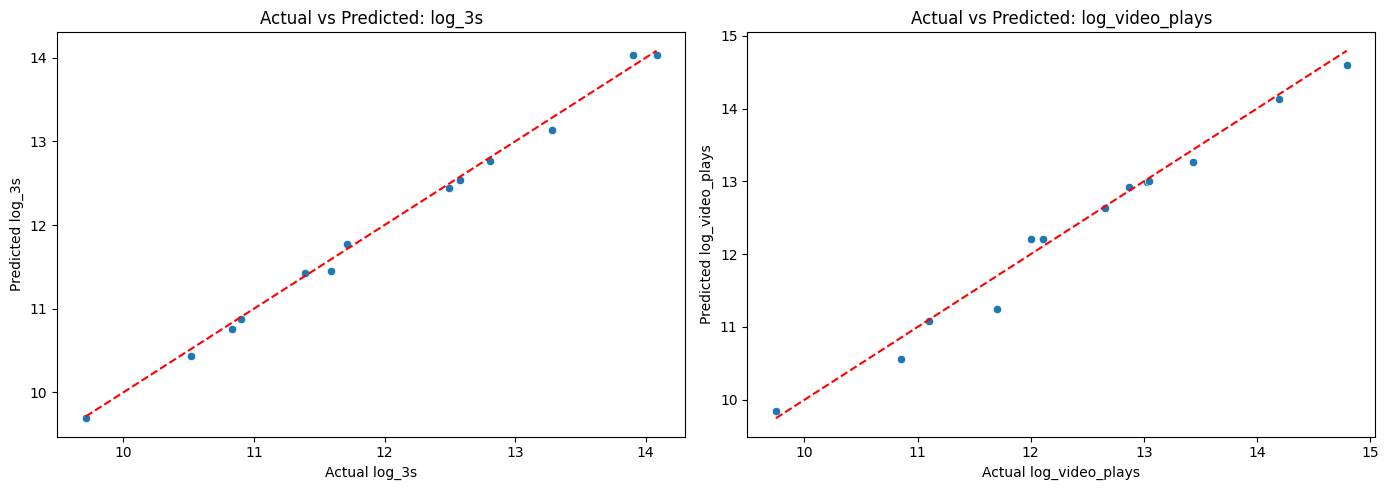

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# log_3s
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test['log_3s'], y=y_pred_multi[:, 0])
plt.plot([y_test['log_3s'].min(), y_test['log_3s'].max()],
         [y_test['log_3s'].min(), y_test['log_3s'].max()], '--r')
plt.xlabel("Actual log_3s")
plt.ylabel("Predicted log_3s")
plt.title("Actual vs Predicted: log_3s")

# log_video_plays
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test['log_video_plays'], y=y_pred_multi[:, 1])
plt.plot([y_test['log_video_plays'].min(), y_test['log_video_plays'].max()],
         [y_test['log_video_plays'].min(), y_test['log_video_plays'].max()], '--r')
plt.xlabel("Actual log_video_plays")
plt.ylabel("Predicted log_video_plays")
plt.title("Actual vs Predicted: log_video_plays")

plt.tight_layout()
plt.show()


## Multi-Output Modeling – Video Campaigns

We trained a MultiOutput XGBoost model to predict both:
- `log_3s`: number of 3-second video plays
- `log_video_plays`: total video plays

### Evaluation Results:

| Target            | RMSE   | R² Score |
|-------------------|--------|----------|
| `log_3s`          | 0.0812 | 0.9960   |
| `log_video_plays` | 0.1846 | 0.9807   |

✅ The model demonstrates high predictive accuracy for both early and total video views and will be adopted for forecasting performance in video-based campaigns.


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_multi = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_multi.fit(X_train, y_train)

rf_preds = rf_multi.predict(X_test)

rf_rmse_3s = np.sqrt(mean_squared_error(y_test['log_3s'], rf_preds[:, 0]))
rf_r2_3s = r2_score(y_test['log_3s'], rf_preds[:, 0])

rf_rmse_plays = np.sqrt(mean_squared_error(y_test['log_video_plays'], rf_preds[:, 1]))
rf_r2_plays = r2_score(y_test['log_video_plays'], rf_preds[:, 1])

print("log_3s")
print(f"RMSE: {rf_rmse_3s:.4f}")
print(f"R² Score: {rf_r2_3s:.4f}")

print("log_video_plays")
print(f"RMSE: {rf_rmse_plays:.4f}")
print(f"R² Score: {rf_r2_plays:.4f}")


log_3s
RMSE: 0.1207
R² Score: 0.9912
log_video_plays
RMSE: 0.1381
R² Score: 0.9892


In [73]:
from sklearn.linear_model import LinearRegression

lr_multi = MultiOutputRegressor(LinearRegression())
lr_multi.fit(X_train, y_train)

lr_preds = lr_multi.predict(X_test)

lr_rmse_3s = np.sqrt(mean_squared_error(y_test['log_3s'], lr_preds[:, 0]))
lr_r2_3s = r2_score(y_test['log_3s'], lr_preds[:, 0])

lr_rmse_plays = np.sqrt(mean_squared_error(y_test['log_video_plays'], lr_preds[:, 1]))
lr_r2_plays = r2_score(y_test['log_video_plays'], lr_preds[:, 1])

print("log_3s")
print(f"RMSE: {lr_rmse_3s:.4f}")
print(f"R² Score: {lr_r2_3s:.4f}")

print("log_video_plays")
print(f"RMSE: {lr_rmse_plays:.4f}")
print(f"R² Score: {lr_r2_plays:.4f}")


log_3s
RMSE: 0.8927
R² Score: 0.5171
log_video_plays
RMSE: 0.9383
R² Score: 0.5017


In [74]:
from sklearn.linear_model import Ridge

ridge_multi = MultiOutputRegressor(Ridge(alpha=1.0))
ridge_multi.fit(X_train, y_train)

ridge_preds = ridge_multi.predict(X_test)

ridge_rmse_3s = np.sqrt(mean_squared_error(y_test['log_3s'], ridge_preds[:, 0]))
ridge_r2_3s = r2_score(y_test['log_3s'], ridge_preds[:, 0])

ridge_rmse_plays = np.sqrt(mean_squared_error(y_test['log_video_plays'], ridge_preds[:, 1]))
ridge_r2_plays = r2_score(y_test['log_video_plays'], ridge_preds[:, 1])

print("log_3s")
print(f"RMSE: {ridge_rmse_3s:.4f}")
print(f"R² Score: {ridge_r2_3s:.4f}")

print("log_video_plays")
print(f"RMSE: {ridge_rmse_plays:.4f}")
print(f"R² Score: {ridge_r2_plays:.4f}")


log_3s
RMSE: 1.3558
R² Score: -0.1139
log_video_plays
RMSE: 1.6345
R² Score: -0.5120


## Model Benchmark – Multi-Output Prediction (Video Campaigns)

We trained and compared several models to predict:
- `log_3s` (3-second video plays)
- `log_video_plays` (total video plays)

### Evaluation Results:

| Model           | RMSE 3s | R² 3s  | RMSE Plays | R² Plays |
|----------------|---------|--------|------------|----------|
| XGBoost         | 0.0812  | 0.9960 | 0.1846     | 0.9807   |
| **Random Forest**   | **0.1207**  | **0.9912** | **0.1381**     | **0.9892**   |
| Linear          | 0.8927  | 0.5171 | 0.9383     | 0.5017   |
| Ridge      | 1.3558  | -0.1139 | 1.6345     | -0.5120  |

### Selected Model:
**Random Forest Regression** – delivers the most consistent and interpretable performance across both video metrics.

This model will be used for predicting early and full video plays in future campaign simulations and dashboards.


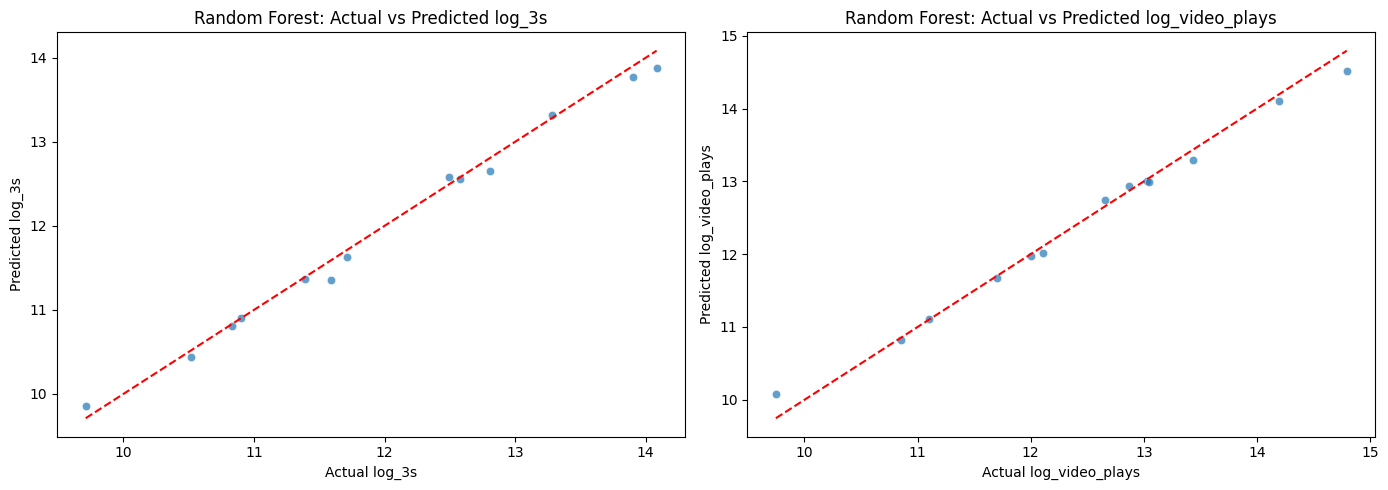

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# log_3s
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test['log_3s'], y=rf_preds[:, 0], alpha=0.7)
plt.plot([y_test['log_3s'].min(), y_test['log_3s'].max()],
         [y_test['log_3s'].min(), y_test['log_3s'].max()], '--r')
plt.xlabel("Actual log_3s")
plt.ylabel("Predicted log_3s")
plt.title("Random Forest: Actual vs Predicted log_3s")

# log_video_plays
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test['log_video_plays'], y=rf_preds[:, 1], alpha=0.7)
plt.plot([y_test['log_video_plays'].min(), y_test['log_video_plays'].max()],
         [y_test['log_video_plays'].min(), y_test['log_video_plays'].max()], '--r')
plt.xlabel("Actual log_video_plays")
plt.ylabel("Predicted log_video_plays")
plt.title("Random Forest: Actual vs Predicted log_video_plays")

plt.tight_layout()
plt.show()


In [76]:
import joblib
# Save the trained Ridge multi-output model
joblib.dump(rf_multi, "../models/rf_video_engagement_model.joblib")

feature_columns = X_train.columns.tolist()
joblib.dump(X_train.columns.tolist(), "../models/video_model_features.pkl")

['../models/video_model_features.pkl']

## Model Persistence – Random Forest Regression (Video Campaigns)

We saved the best-performing Random Forest Regression model (`rf_multi`) for predicting both:
- `log_3s` (early video plays)
- `log_video_plays` (total plays)

-  File: `../models/rf_video_engagement_model.joblib`
-  Ready for reuse in dashboarding, forecasting, and campaign analysis
